# Investment Tool for Simulation & Risk Assessments

![Image of graph](https://www.image-illustration.net/wp-content/uploads/2018/01/financial-analysis-minimal-wallpaper.jpg)

### Purpose 
From deciding how much you would need to add to your portfolio to make it risk averse, to simulating new portfolios to see the optimal allocation to minimise risk and maximise returns. 

#### Features: 
1. Correlation table of portfolios
2. Buy quantity based on risk assessment of financial asset into current portfolio
3. Portfolio simulations for reallocation purposes to maximise returns given the amount of risk taken

### Import modules needed

In [3]:
from financelib.portfolio import Portfolio, merge_dataframes
from financelib import analytics
import pandas as pd
import numpy as np
%config IPCompleter.greedy=True

### Set up portfolio with your holdings

In [4]:

portfolio_list = ["AMZN", # Amazon
                  "GOOG", # Alphapet C
                  "ABB", # ABB
                  "ARISE.ST", # Arise
                  "ATRLJ-B.ST", # Atrium Ljungberg
                  "AXFO.ST" # Axfood
                  ] 

my_portfolio = Portfolio(portfolio_list)


### Correlation table
- To assess what how the returns are correlated
- Number closer to zero = the better 

In [5]:
# Calc correlations
my_portfolio_correlation = analytics.correlation_table(my_portfolio, "5y")
# Pretty print
my_portfolio_correlation.reset_index(drop=True).style.background_gradient(cmap='viridis').set_precision(2)

,AMZN,GOOG,ABB,ARISE.ST,ATRLJ-B.ST,AXFO.ST
0,1.00,0.95,0.50,0.68,0.53,0.86
1,0.95,1.00,0.61,0.67,0.66,0.87
2,0.50,0.61,1.00,0.19,0.23,0.28
3,0.68,0.67,0.19,1.00,0.56,0.75
4,0.53,0.66,0.23,0.56,1.00,0.76
5,0.86,0.87,0.28,0.75,0.76,1.00


# Create portfolio and sum up all stock returns

In [6]:
portfolio = Portfolio(portfolio_list)
portfolio_total_returns = portfolio.total_returns('1y')
print(portfolio_total_returns)

            Portfolio
Date                 
2019-09-04     427.89
2019-09-05    3483.82
2019-09-06    3474.44
2019-09-09    3471.91
2019-09-10    3457.85
...               ...
2020-08-31    5463.24
2020-09-01    5540.52
2020-09-02    5645.88
2020-09-03    5399.81
2020-09-04    5273.40

[260 rows x 1 columns]


# Plot stock total returns

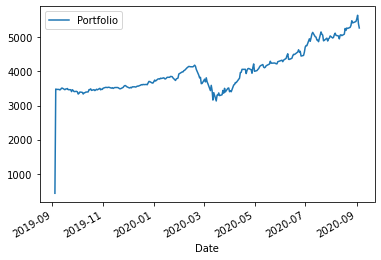

In [7]:
portfolio_total_returns.plot()
# portfolio_returns.plot(logy=True)


# Stocks only

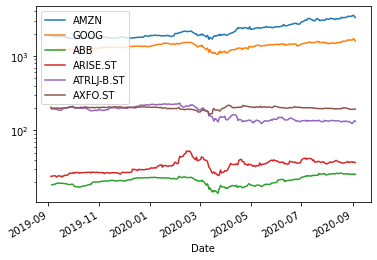

In [8]:

portfolio_stock_returns = portfolio.returns('1y')
portfolio_stock_returns.plot(logy=True)

# Portfolio + stocks

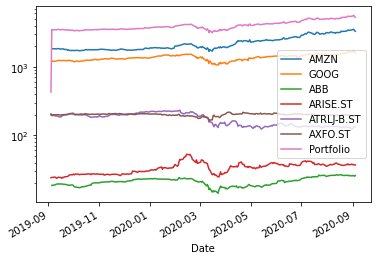

In [9]:
# merge portfolio dataframe + stock dataframes
merged_data = merge_dataframes([portfolio_stock_returns, portfolio_total_returns])
# plot merged data
merged_data.plot(logy=True)

# Dags att gå lös

Analysis walk through = https://www.youtube.com/watch?v=kBwOy-6CtAQ

Monte carlo = https://www.youtube.com/watch?v=_T0l015ecK4

In [10]:
%matplotlib inline
import os
import random
import datetime
import numpy as np
from ipywidgets import interact, fixed, IntSlider, SelectMultiple
import matplotlib.pyplot as plt
from numpy.linalg import cholesky
import seaborn as sns
import yfinance as yf

In [11]:
all_data_start, all_data_end = "2016-01-01", "2019-10-01"
default_start, default_end = "2017-01-01", "2018-01-01"

In [12]:
# Test stock 1
aapl = yf.Ticker("AAPL")
aapl = aapl.history(start="2015-01-01", end="2016-01-01")
aapl.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-12-31,25.74,25.81,25.14,25.18,165613600,0.0,0
2015-01-02,25.41,25.42,24.49,24.94,212818400,0.0,0
2015-01-05,24.70,24.79,24.05,24.24,257142000,0.0,0


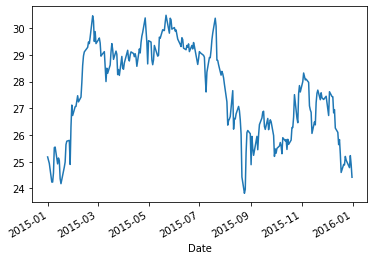

In [13]:
aapl.Close.plot()

In [14]:
class Portfolio:
    def __init__(self, tickers: list):
        self.tickers = tickers

        #create list of holdings based on ticker-list
        self.holdings = list(yf.Ticker(ticker) for ticker in self.tickers)
    
    def get_holdings(self):
        '''
        :return: list of holdings
        '''
        return self.holdings

    def returns(self):
        '''
        Creates dataframe of returns within given period

        :param period: period of returns, i.e. "1d", "1y"
        :return: dataframe of portfolio returns
        '''
        returnsDF = [None]
        for stock in self.holdings:
            returns = pd.DataFrame(stock.history(start=default_start, end=default_end), columns=["Close"])
            returnsDF.append(returns)

        # slå samman tickerdatan (y-axeln, därav axis=1)
        portfolio_returns = pd.concat(returnsDF, axis=1)
        # byter namn på kolumnerna
        portfolio_returns.columns = self.tickers
        return portfolio_returns

In [15]:
portfolio_list = ["AAPL", "FB", "GOOG"]

test_portfolio = Portfolio(portfolio_list)
print(test_portfolio.returns())

             AAPL      FB     GOOG
Date                              
2017-01-03  27.55  116.86   786.14
2017-01-04  27.52  118.69   786.90
2017-01-05  27.66  120.67   794.02
2017-01-06  27.97  123.41   806.15
2017-01-09  28.22  124.90   806.65
...           ...     ...      ...
2017-12-22  42.18  177.20  1060.12
2017-12-26  41.11  175.99  1056.74
2017-12-27  41.11  177.62  1049.37
2017-12-28  41.23  177.92  1048.14
2017-12-29  40.78  176.46  1046.40

[251 rows x 3 columns]


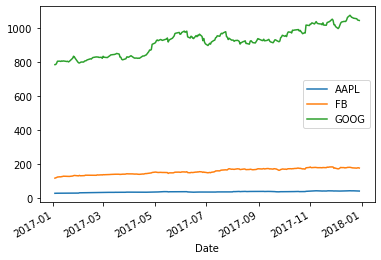

In [16]:
test_portfolio.returns().plot()

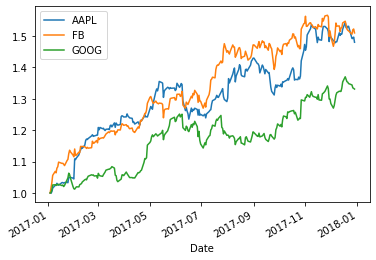

In [17]:
# Logged returns 
log_returns = test_portfolio.returns()/test_portfolio.returns().iloc[0]
log_returns.plot()

In [18]:
log_returns["PORTFOLIO"] = log_returns.iloc[:,0:len(test_portfolio.get_holdings())].sum(axis=1) / len(test_portfolio.get_holdings())

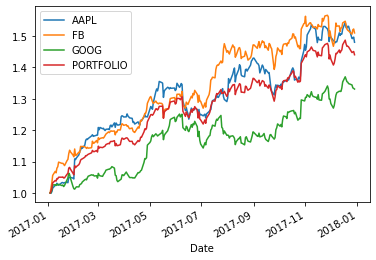

In [19]:
log_returns.plot()

In [20]:
daily_pct_change = np.log(log_returns.pct_change() +1 )
vols = daily_pct_change.std() * np.sqrt(252)
vols

AAPL         0.175677
FB           0.170060
GOOG         0.153762
PORTFOLIO    0.141915
dtype: float64

In [21]:
# NEEDS TO BE FIXED 

def diversicheck(symbols, start_day=0, **activate): 
    start = datetime.datetime.strptime(all_data_start, "%Y-%n-%d") + datetime
    end = start + datetime.timedelta(days=365)
    filtered = [symbol for symbol in symbols if activate.get(symbol, True)]
    prices = [stock_hist(symbol, start=start, end=end) for sumbol in filtered
    unit_pos = [p / p[0] for p in prices]
    basket = sum(u for u in unit_pos) / len(unit_pos)
    for p in unit_pos:
        p.plot(color="b", alpha=0.3)
    basket.plot(figsize=(20,10))
    print(f"Backtest form {start} to {end}")

SyntaxError: invalid syntax (<ipython-input-21-953bbc15603c>, line 8)

In [22]:
prf_stocks = ["AAPL", "FB", "GOOGL"]
active = dict(zip(prf_stocks, [True] * len (prf_stocks)))

_ = interact(diversicheck, symbols=fixed(prf_stocks), start_day=0)

NameError: name 'diversicheck' is not defined

In [23]:
df = log_returns
prf_stocks = ["AAPL", "FB", "GOOG", "PORTFOLIO"]
def multiplot(symbols):
    opts = df.columns.values
    df.loc[:, symbols].plot()

interactive = interact(multiplot, symbols=prf_stocks)

interactive(children=(Dropdown(description='symbols', options=('AAPL', 'FB', 'GOOG', 'PORTFOLIO'), value='AAPL…

In [24]:
sel_mul = SelectMultiple(description="symbols", options=df.columns,value=prf_stocks, disabled=False)
@interact(variables=sel_mul)
def plot_multiple(variables):
    df[list(variables)].plot()

interactive(children=(SelectMultiple(description='symbols', index=(0, 1, 2, 3), options=('AAPL', 'FB', 'GOOG',…

In [25]:
prf_returns = portfolio.total_returns('1y')
prf_pct = (prf_returns.pct_change() +1)
simulated = pd.DataFrame([((prf_pct.iloc[random.choices(range(len(prf_returns)), k=100)]).mean(axis=1)).cumprod().values for x in range (1000)]).T

In [26]:
print(prf_pct)

            Portfolio
Date                 
2019-09-04        NaN
2019-09-05   8.141859
2019-09-06   0.997308
2019-09-09   0.999272
2019-09-10   0.995950
...               ...
2020-08-31   1.005838
2020-09-01   1.014145
2020-09-02   1.019016
2020-09-03   0.956416
2020-09-04   0.976590

[260 rows x 1 columns]


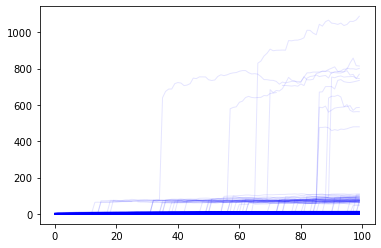

In [27]:
simulated.plot(legend=False, linewidth=1, alpha=0.1, color='blue')

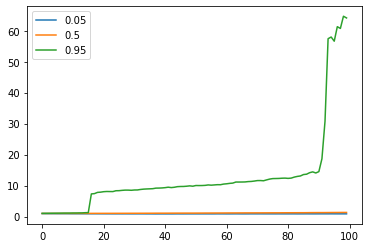

In [28]:
simulated.quantile([0.05, 0.50, 0.95], axis=1).T.plot()

In [29]:
quantiles = simulated.quantile([0.05, 0.50, 0.95])